# SnowModel comparisons
---  
*J. Michelle Hu  
University of Utah  
Sept 2024*  


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [4]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys'
# aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"

In [5]:
# Basin-specific variables
basin = 'blue'

In [6]:
if basin == 'blue':
    basindirs = [h.fn_list(workdir, f'*{basin}*')[1], h.fn_list(workdir, f'*{basin}*')[0]] # Blue River
elif basin == 'yampa':
    # basindirs =h.fn_list(workdir, f'__{basin}*') # Yampa River previous runs
    basindirs =h.fn_list(workdir, f'{basin}*') # Yampa River newest runs
elif basin == 'animas':
    basindirs = h.fn_list(workdir, f'__{basin}*') # Animas previous runs
    # basindirs = [h.fn_list(workdir, f'{basin}*')[0], h.fn_list(workdir, f'__{basin}*')[1]]
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_river_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/__blue_river_100m_isnobal_solar_albedo']

In [7]:
# Get the WY from the directory name - assumes there is only one WY per basin
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
print(WY)

2019


In [8]:
# Figure out filenames
# Basin polygon file if not in poly_dir, all should now be there
# poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
poly_fn = h.fn_list(poly_dir, f'*{basin}*shp')[0]
print(poly_fn)

/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/blue_river_basin_outline_HUC10dissolved_32613.shp


## Load and take a look at SnowModel outputs

In [9]:
snowmodel_dir = '/uufs/chpc.utah.edu/common/home/u6058223/SnowModel'
snowmodel_workdir = h.fn_list(snowmodel_dir, f'*{basin}*')[0]
print(snowmodel_workdir)
sm_files = h.fn_list(snowmodel_workdir, f'{WY}/*')
len(sm_files)

/uufs/chpc.utah.edu/common/home/u6058223/SnowModel/blue


273

In [10]:
%%time
chunks = 'auto'
ds_list = [np.squeeze(xr.open_dataset(day_fn, chunks=chunks)) for day_fn in sm_files]
len(ds_list)

CPU times: user 4.08 s, sys: 660 ms, total: 4.74 s
Wall time: 6.56 s


273

In [11]:
print(PurePath(sm_files[0]).stem, PurePath(sm_files[-1]).stem)

sm_swed_20181001 sm_swed_20190630


In [12]:
ds_list[0]

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 741, x: 572)
Coordinates:
  * y            (y) float64 6kB 4.433e+06 4.433e+06 ... 4.357e+06 4.357e+06
  * x            (x) float64 5kB 3.745e+05 3.746e+05 ... 4.333e+05 4.334e+05
    date         datetime64[ns] 8B 2018-10-01
Data variables:
    spatial_ref  int64 8B ...
    swed         (y, x) float32 2MB dask.array<chunksize=(741, 572), meta=np.ndarray>

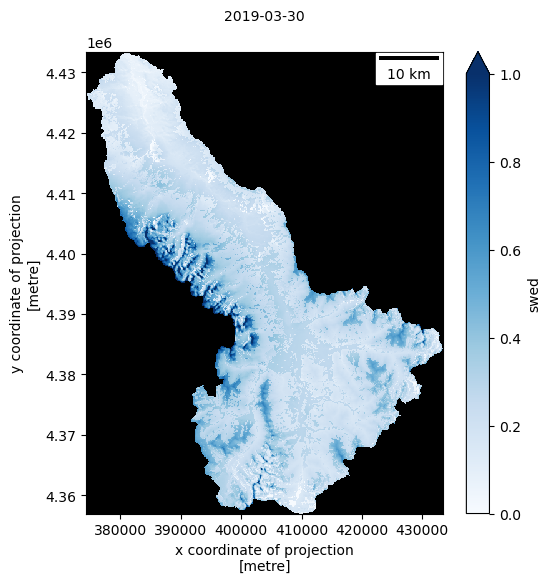

In [13]:
jdx = 180
title = pd.Timestamp(ds_list[jdx].date.values).strftime('%Y-%m-%d')
figsize = (6,6)
h.plot_one(ds_list[jdx]['swed'], title=title, figsize=figsize, sd_switch=True, setfc='k', vmin=0, vmax=1)

### SNOTEL extraction and point specification
- identify SNOTEL sites within the specified basin
- extract site metadata (site name, site number, and coordinates)
- extract snow depth values for WY of interest

In [14]:
# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
print(sitenames)

155    Copper Mountain (415)
167       Fremont Pass (485)
170       Grizzly Peak (505)
Name: site_name, dtype: object


In [15]:
ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs = proc.get_snotel(sitenums, sitenames, ST_arr, WY=WY, snowvar="SWE")
gdf_metloom

,geometry
0,POINT (399255.157 4371717.635)
1,POINT (396832.750 4359646.780)
2,POINT (425406.434 4388880.047)


<Axes: xlabel='datetime'>

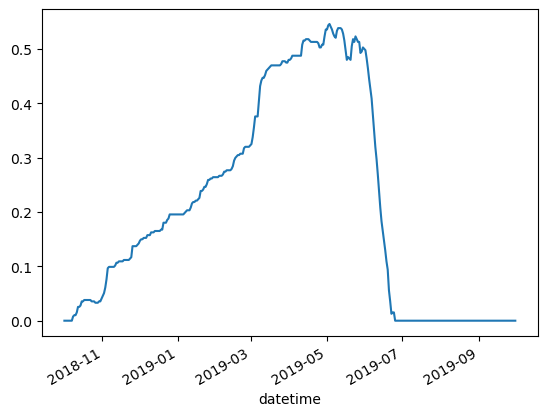

In [16]:
snotel_dfs[sitenames.iloc[0]]["SWE_m"].plot()

## Extract SnowModel data at these sites

In [17]:
%%time
snow_var_data = [ds.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]

# Concatenate all the days to form a time series
snowmodel_ts = xr.concat(snow_var_data, dim='time')
snowmodel_ts

CPU times: user 3.47 s, sys: 588 ms, total: 4.05 s
Wall time: 7.53 s


<xarray.Dataset> Size: 14kB
Dimensions:      (time: 273, y: 3, x: 3)
Coordinates:
  * y            (y) float64 24B 4.372e+06 4.36e+06 4.389e+06
  * x            (x) float64 24B 3.992e+05 3.968e+05 4.254e+05
    date         (time) datetime64[ns] 2kB 2018-10-01 2018-10-02 ... 2019-06-30
Dimensions without coordinates: time
Data variables:
    spatial_ref  (time) int64 2kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    swed         (time, y, x) float32 10kB dask.array<chunksize=(1, 3, 3), meta=np.ndarray>

## Plot em up individually against SNOTEL

In [18]:
# Plotting params
linewidth = 1.5
snotelcolor = 'dimgray'
isnobalcolors = ['mediumblue', 'cornflowerblue']
isnobal_alpha = 0.6

Copper Mountain (415)
Fremont Pass (485)
Grizzly Peak (505)


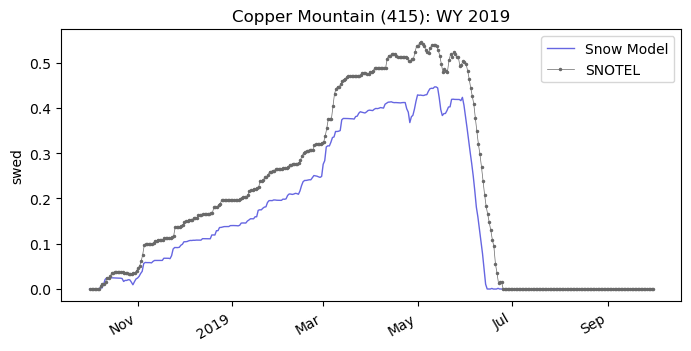

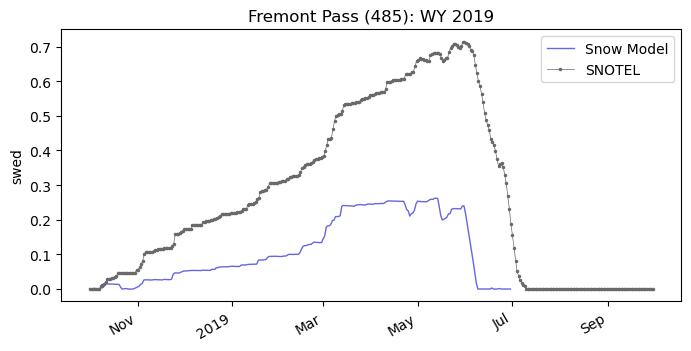

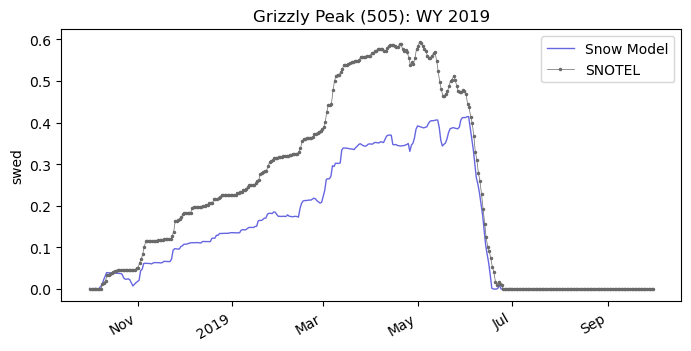

In [19]:
# No SDD version
figsize = (8, 4)
for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    # Extract SNOTEL data for this site
    snotel_df = snotel_dfs[sitename]
    print(f'{sitename}')

    # Extract model data for this site
    sm_ts = snowmodel_ts['swed'][:, jdx, jdx]

    fig, ax = plt.subplots(1, figsize=figsize)
    sm_ts.plot(ax=ax, x='date', color=isnobalcolors[0], label='Snow Model', linewidth=linewidth/3*2, linestyle='-', alpha=isnobal_alpha)

    # Plot WY time series of snow depth
    snotel_df['SWE_m'].plot(ax=ax, label=f'SNOTEL',
                                    # linestyle=(0, (3, 1, 1, 1, 1, 1)),
                                    linewidth=linewidth/3,
                                    color=snotelcolor, marker='.', markersize=3,
                                    )
    
    plt.legend()
    plt.title(f'{sitename}: WY {WY}')
    plt.xlabel('');


In [20]:
snowmodel_list = []
snotel_list = []

for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    snowmodel_list.append(snowmodel_ts['swed'][:, jdx, jdx].to_series())
    snotel_list.append(snotel_dfs[sitenames.iloc[jdx]]['SWE_m'])
    
snowmodel_megadf = pd.concat(snowmodel_list, axis=1)
snowmodel_megadf.columns = sitenames

snotel_megadf = pd.concat(snotel_list, axis=1)
snotel_megadf.columns = sitenames

In [24]:
snowmodel_megadf.index = snowmodel_ts['date']

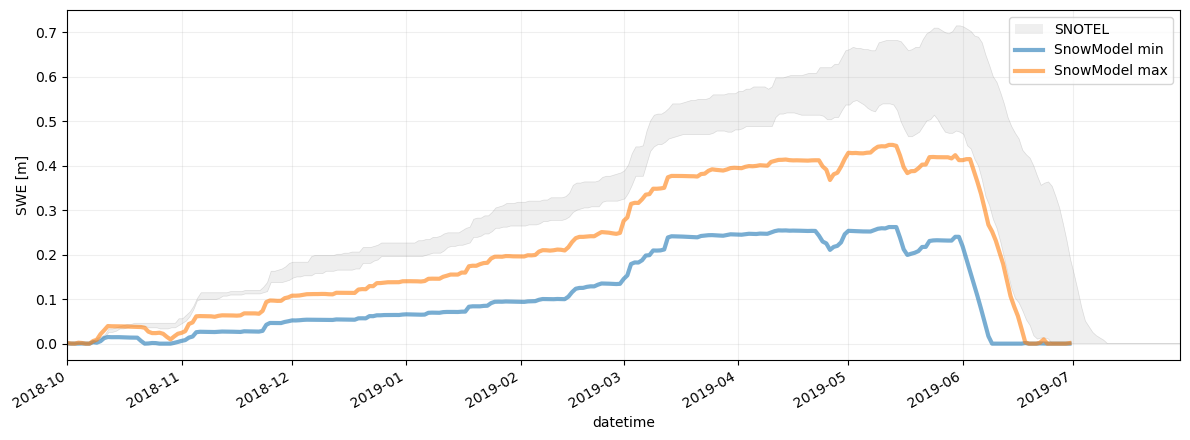

In [31]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=(12, 4.5))

snotelon = True
snotel_dotson = False
gridon = True

if snotelon:
    # Plot WY time series of snow depth
    if snotel_dotson:
        snotel_megadf.plot(ax=ax, legend=False,
                           linewidth=linewidth/3,
                           color=snotelcolor, marker='.', markersize=3,
                           alpha=alpha*2
                          )

    snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    ax.fill_between(snotel_megadf.index, 
                    snotel_megadf.min(axis=1), 
                    snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                    alpha=alpha)

# SnowModel
snowmodel_megadf.min(axis=1).plot(ax=ax, x='Date', label='SnowModel min', linewidth=linewidth*2, linestyle='-', 
                              alpha=isnobal_alpha,
                             )
snowmodel_megadf.max(axis=1).plot(ax=ax, x='Date', label='SnowModel max', linewidth=linewidth*2, linestyle='-', 
                              alpha=isnobal_alpha
                             )

# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
ax.set_ylabel('SWE [m]')
plt.legend()
plt.tight_layout()
if gridon:
    ax.grid(alpha=0.2)
# plt.legend(bbox_to_anchor=(0.205,1))
# plt.legend(bbox_to_anchor=(0.195,1))
outname = f'{basin}_ts.png'
# outname = f'{basin}_snotel_nwm_ts.png'
# outname = f'{basin}_snotel.png'
# plt.savefig(outname, dpi=300)

## iSnobal output extraction

- iSnobal time decay
- iSnobal HRRR-MODIS

In [32]:
%%time
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
varname = 'snow'
days = h.fn_list(basindirs[0], f"*/*/{month}*/{varname}.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/{varname}.nc")]

print(len(days[0]), len(days[1]))

365 365
CPU times: user 25 ms, sys: 43.3 ms, total: 68.3 ms
Wall time: 312 ms


In [33]:
%%time

chunks = 'auto'
# drop_var_list = ['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']
drop_var_list = ['specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']


ds_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn, chunks=chunks, drop_variables=drop_var_list) for day_fn in days[1]]

snow_var_data = [ds.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_list]
snow_updated_var_data = [ds.sel(x=list(gdf_metloom.geometry.x.values), y=list(gdf_metloom.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
depth_ts = xr.concat(snow_var_data, dim='time')
depth_sol_ts = xr.concat(snow_updated_var_data, dim='time')

# do some cleanup
del ds_list, ds_sol_list, snow_var_data, snow_updated_var_data

depth_sol_ts

CPU times: user 24 s, sys: 3.92 s, total: 27.9 s
Wall time: 1min 1s


<xarray.Dataset> Size: 29kB
Dimensions:       (time: 365, y: 3, x: 3)
Coordinates:
  * time          (time) datetime64[ns] 3kB 2018-10-01T22:00:00 ... 2019-09-3...
  * y             (y) float32 12B 4.372e+06 4.36e+06 4.389e+06
  * x             (x) float32 12B 3.993e+05 3.968e+05 4.254e+05
Data variables:
    thickness     (time, y, x) float32 13kB dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
    snow_density  (time, y, x) float32 13kB dask.array<chunksize=(1, 3, 3), meta=np.ndarray>
Attributes:
    last_modified:  [2024-08-12 11:34:52] Data added or updated

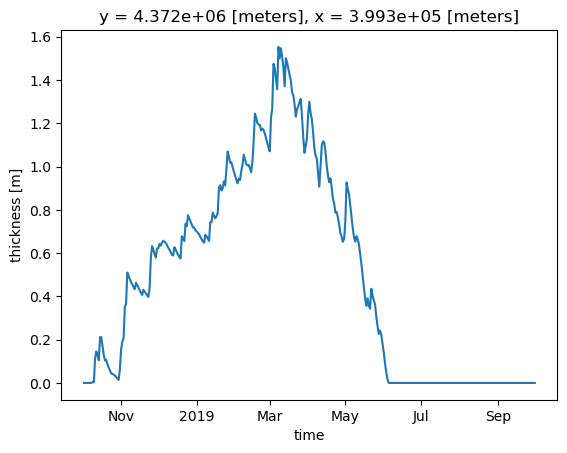

In [34]:
depth_sol_ts['thickness'][:, 0, 0].plot()

## NWM

In [35]:
# Read in NWM proj4 string
with open(proj_fn, "r") as f:
    proj4 = f.read()
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [36]:
# Convert snotel points to NWM projection to extract time series
gdf_metloom_nwm = gdf_metloom.to_crs(crs=proj4)
gdf_metloom_nwm.bounds

,minx,miny,maxx,maxy
0,-762539.268202,-11409.052112,-762539.268202,-11409.052112
1,-766065.695077,-22853.588347,-766065.695077,-22853.588347
2,-735646.339191,2636.642421,-735646.339191,2636.642421


In [37]:
# Use gdf_metloom in nwm coords to extract NWM data
nwm_ds = proc.get_nwm_retrospective_LDAS(gdf_metloom_nwm, 
                                         start=f'{WY-1}-10-01', 
                                         end=f'{WY}-09-30', 
                                         # var='SNOWH',
                                         var='SNEQV'
                                        )

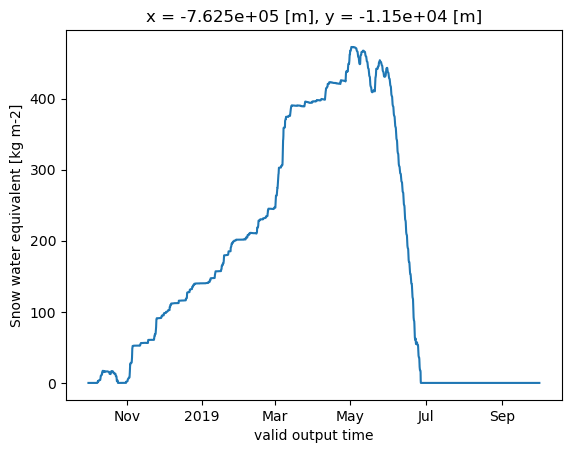

In [38]:
nwm_ds[0].plot()

## Prepare for big plot

#### Calculate an iSnobal snow water equivalent from modeled density and depth

In [39]:
depth_ts = depth_ts.assign(swe=depth_ts['thickness'] * depth_ts['snow_density'])
depth_sol_ts = depth_sol_ts.assign(swe=depth_sol_ts['thickness'] * depth_sol_ts['snow_density'])

In [40]:
depth_list = []
depth_sol_list = []
nwm_list = []
snotel_list = []

for jdx, (sitenum, sitename) in enumerate(zip(sitenums, sitenames)):
    depth_list.append(depth_ts['swe'][:, jdx, jdx].to_series())
    depth_sol_list.append(depth_sol_ts['swe'][:, jdx, jdx].to_series())
    nwm_list.append(nwm_ds[jdx].to_series())
    snotel_list.append(snotel_dfs[sitenames.iloc[jdx]]['SWE_m'])

In [41]:
%%time
depth_megadf = pd.concat(depth_list, axis=1)
depth_megadf.columns = sitenames
depth_megadf = depth_megadf / 1000

depth_sol_megadf = pd.concat(depth_sol_list, axis=1)
depth_sol_megadf.columns = sitenames
depth_sol_megadf = depth_sol_megadf / 1000

nwm_megadf = pd.concat(nwm_list, axis=1)
nwm_megadf.columns = sitenames
nwm_megadf = nwm_megadf / 1000

snotel_megadf = pd.concat(snotel_list, axis=1)
snotel_megadf.columns = sitenames

CPU times: user 5.02 ms, sys: 726 μs, total: 5.75 ms
Wall time: 5.52 ms


# Plot the big plot

In [42]:
# Plotting params
linestyles = ['-', '--']
linewidth = 1.5

snotelcolor = 'dimgray'
isnobalcolors = ['mediumblue', 'cornflowerblue']
nwm_color = 'salmon'#'tomato'
alpha = 0.7
isnobal_alpha = 0.6
figsize = (12, 4)

In [47]:
import seaborn as sns

In [48]:
sns.set_palette('icefire')

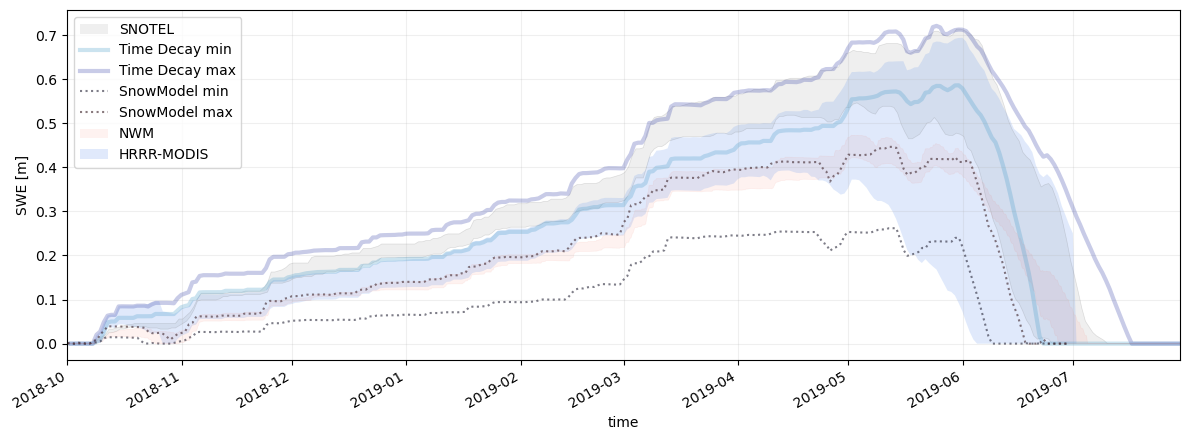

In [49]:
alpha = 0.1
fig, ax = plt.subplots(1, figsize=(12, 4.5))

snotelon = True
snotel_dotson = False
nwmon = True
timedecayon = True
snowmodelon = True
modishrron = True
gridon = True

if snotelon:
    # Plot WY time series of snow depth
    if snotel_dotson:
        snotel_megadf.plot(ax=ax, legend=False,
                           linewidth=linewidth/3,
                           color=snotelcolor, marker='.', markersize=3,
                           alpha=alpha*2
                          )

    snotel_megadf.min(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    snotel_megadf.max(axis=1).plot(ax=ax, legend=False,
                                   # linewidth=0,
                                   linewidth=linewidth/3,
                                   color=snotelcolor, marker='.', markersize=0, #markersize=3,
                                   alpha=alpha*2
                                  )

    ax.fill_between(snotel_megadf.index, 
                    snotel_megadf.min(axis=1), 
                    snotel_megadf.max(axis=1), facecolor=snotelcolor, label='SNOTEL', 
                    alpha=alpha)

# iSnobal-HRRR
if timedecayon:
    depth_megadf.min(axis=1).plot(ax=ax, label='Time Decay min', linewidth=linewidth*2, linestyle='-', 
                                  alpha=isnobal_alpha/2,
                                 )
    depth_megadf.max(axis=1).plot(ax=ax, label='Time Decay max', linewidth=linewidth*2, linestyle='-', 
                                  alpha=isnobal_alpha/2
                                 )

    
# SnowModel
if snowmodelon:
    snowmodel_megadf.min(axis=1).plot(ax=ax, label='SnowModel min', linewidth=linewidth, linestyle=':', 
                                  alpha=isnobal_alpha,
                                 )
    snowmodel_megadf.max(axis=1).plot(ax=ax, label='SnowModel max', linewidth=linewidth, linestyle=':', 
                                  alpha=isnobal_alpha
                                 )

# NWM
if nwmon:
    ax.fill_between(nwm_megadf.index, nwm_megadf.min(axis=1), nwm_megadf.max(axis=1), facecolor=nwm_color, label='NWM', alpha=alpha)
    nwm_megadf.min(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       linewidth=linewidth/3,
                       color=nwm_color, marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )

    nwm_megadf.max(axis=1).plot(ax=ax, legend=False,
                       # linewidth=0,
                       linewidth=linewidth/3,
                       color=nwm_color, marker='.', markersize=0, #markersize=3,
                       alpha=alpha
                      )
    
# HRRR-MODIS
if modishrron:
    ax.fill_between(depth_sol_megadf.index, depth_sol_megadf.min(axis=1),depth_sol_megadf.max(axis=1), facecolor=isnobalcolors[1], label='HRRR-MODIS', alpha=isnobal_alpha/3)
    
# Center the plot on the data
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-07-30'));
ax.set_ylabel('SWE [m]')
plt.legend()
plt.tight_layout()
if gridon:
    ax.grid(alpha=0.2)
outname = f'{basin}_ts.png'
# plt.savefig(outname, dpi=300)